In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

In [3]:
# load the featurized data
train = pd.read_csv("/content/drive/MyDrive/datasets/cs2/train_FE.csv")
test = pd.read_csv("/content/drive/MyDrive/datasets/cs2/test_FE.csv")
print(train.shape, test.shape)

(200000, 402) (200000, 401)


In [4]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

## 1. LightGBM

In [ ]:
# parameters. Credits: https://www.kaggle.com/gpreda/santander-eda-and-prediction
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.899134	valid_1's auc: 0.879898
[2000]	training's auc: 0.91173	valid_1's auc: 0.888597
[3000]	training's auc: 0.920336	valid_1's auc: 0.893847
[4000]	training's auc: 0.927006	valid_1's auc: 0.897212
[5000]	training's auc: 0.932465	valid_1's auc: 0.899489
[6000]	training's auc: 0.937188	valid_1's auc: 0.900843
[7000]	training's auc: 0.94147	valid_1's auc: 0.901692
[8000]	training's auc: 0.945519	valid_1's auc: 0.902491
[9000]	training's auc: 0.949281	valid_1's auc: 0.902723
[10000]	training's auc: 0.952842	valid_1's auc: 0.903021
[11000]	training's auc: 0.956236	valid_1's auc: 0.903185
[12000]	training's auc: 0.959445	valid_1's auc: 0.903102
[13000]	training's auc: 0.962417	valid_1's auc: 0.903178
[14000]	training's auc: 0.965273	valid_1's auc: 0.903286
Early stopping, best iteration is:
[11396]	training's auc: 0.957572	valid_1's auc: 0.903366
Fold 1
Training until validation scores don't impr

In [ ]:
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("/content/drive/MyDrive/datasets/cs2/submission_v1.csv", index=False)

## Logistic Regression without scaling

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [6]:
X = train[features]
y = target

In [7]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(180000, 400) (20000, 400) (180000,) (20000,)


In [ ]:
# hyperparameter tuning
params = {
    "C": [10 ** x for x in range(-5, 4)]
}

lr = LogisticRegression(penalty="l2", class_weight={20, 80})
clf = RandomizedSearchCV(lr, params, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=10)
clf.fit(np.array(X_train), y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
print("Best hyperparameters: {}".format(clf.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 10.0min finished


Best hyperparameters: {'C': 10}


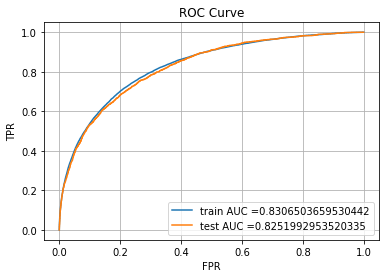

In [ ]:
clf_ = clf.best_estimator_
clf_.fit(X_train, y_train)

y_train_pred = clf_.predict_proba(X_train) 
y_test_pred = clf_.predict_proba(X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:, 1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:, 1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

## Logistic regression with scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
X_train_scaled = scale.fit_transform(X_train)
X_test_scaled = scale.transform(X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(180000, 400) (20000, 400)


In [ ]:
# hyperparameter tuning
params = {
    "C": [10 ** x for x in range(-5, 4)]
}

lr = LogisticRegression(penalty="l2", class_weight={20, 80})
clf = RandomizedSearchCV(lr, params, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1, verbose=10)
clf.fit(np.array(X_train_scaled), y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
print("Best hyperparameters: {}".format(clf.best_params_))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  5.2min finished


Best hyperparameters: {'C': 0.1}


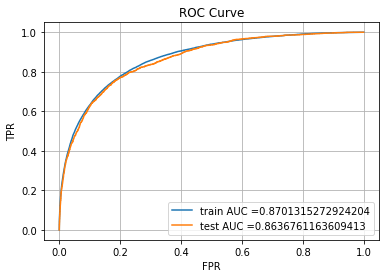

In [ ]:
clf_ = clf.best_estimator_
clf_.fit(X_train_scaled, y_train)

y_train_pred = clf_.predict_proba(X_train_scaled) 
y_test_pred = clf_.predict_proba(X_test_scaled)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred[:, 1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred[:, 1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

## XGBoost

In [10]:
import xgboost as xgb
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
# xgboost hyperparameter tuning
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict_proba(X_test)
    test_fpr, test_tpr, tr_thresholds = roc_curve(y_test, pred[:, 1])
    auc_score = auc(test_fpr, test_tpr)
    print ("SCORE:", auc_score)
    return {'loss': -auc_score, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.4999166203446359
SCORE:
0.4999166203446359
SCORE:
0.5326829996764372
SCORE:
0.4999166203446359
SCORE:
0.5319539462221964
SCORE:
0.5326951955066248
SCORE:
0.5
SCORE:
0.4999166203446359
SCORE:
0.5
SCORE:
0.5319655198161499
SCORE:
0.4999166203446359
SCORE:
0.4999166203446359
SCORE:
0.5319655198161499
SCORE:
0.5326951955066248
SCORE:
0.4999166203446359
SCORE:
0.5319539462221964
SCORE:
0.5326951955066248
SCORE:
0.5319655198161499
SCORE:
0.4999166203446359
SCORE:
0.4999166203446359
SCORE:
0.5326951955066248
SCORE:
0.5326951955066248
SCORE:
0.5319655198161499
SCORE:
0.5326951955066248
SCORE:
0.7731945055157784
SCORE:
0.7731801664274514
SCORE:
0.7735355324544592
SCORE:
0.7733967599467918
SCORE:
0.4999166203446359
SCORE:
0.7730032854073159
SCORE:
0.5319655198161499
SCORE:
0.5326951955066248
SCORE:
0.5326951955066248
SCORE:
0.5326951955066248
SCORE:
0.5326951955066248
SCORE:
0.5319655198161499
SCORE:
0.5326951955066248
SCORE:
0.5326951955066248
SCORE:
0.5326951955066248
SCORE:
0.4999166

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7122987011494589, 'gamma': 1.3885551115613475, 'max_depth': 7.0, 'min_child_weight': 7.0, 'reg_alpha': 41.0, 'reg_lambda': 0.7437661970104388}


In [25]:
# xgboost training using the best parameters found above
clf_ = xgb.XGBClassifier(colsample_bytree= 0.7122987011494589, gamma= 1.3885551115613475, 
                        max_depth= 7, min_child_weight= 7, reg_alpha= 41, reg_lambda= 0.7437661970104388, n_estimators= 180)

In [26]:
evaluation = [( X_train, y_train), ( X_test, y_test)]
    
clf_.fit(X_train, y_train,
        eval_set=evaluation, eval_metric="auc",
        early_stopping_rounds=10,verbose=True)

[0]	validation_0-auc:0.634155	validation_1-auc:0.634128
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.674455	validation_1-auc:0.658181
[2]	validation_0-auc:0.69663	validation_1-auc:0.678412
[3]	validation_0-auc:0.70907	validation_1-auc:0.690961
[4]	validation_0-auc:0.719747	validation_1-auc:0.701494
[5]	validation_0-auc:0.728995	validation_1-auc:0.709687
[6]	validation_0-auc:0.745767	validation_1-auc:0.722856
[7]	validation_0-auc:0.753414	validation_1-auc:0.728992
[8]	validation_0-auc:0.763208	validation_1-auc:0.736191
[9]	validation_0-auc:0.769644	validation_1-auc:0.743198
[10]	validation_0-auc:0.772364	validation_1-auc:0.74532
[11]	validation_0-auc:0.776233	validation_1-auc:0.749499
[12]	validation_0-auc:0.778331	validation_1-auc:0.751392
[13]	validation_0-auc:0.783167	validation_1-auc:0.756165
[14]	validation_0-auc:0.787397	validation_1-auc:0.758745
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7122987011494589,
              gamma=1.3885551115613475, learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=7, missing=None, n_estimators=180,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=41, reg_lambda=0.7437661970104388,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)

In [27]:
print(clf_.best_iteration)
predictions = clf_.predict(test[features])

179

## Final Conclusion

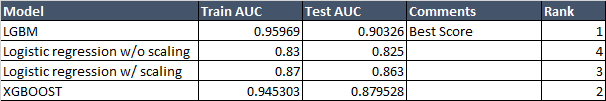

### As we can see above LGBM performs the best amongst other model expirements.

## With the scoring of LGBM i managed to get into the top 10% of the scores for this competition. Screenshot below

## Top score was 0.92573

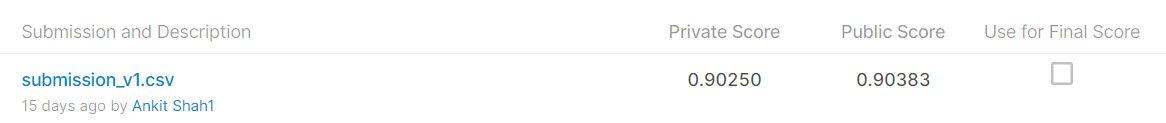

